# Vegetable Image Classification Using Pytorch

## Import the required libraries and functions.

In [1]:
import torch 
import numpy as np
import cv2
from PIL import Image
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
!pip install opendatasets --upgrade --quiet

## Downloading and preparing the data.

In [3]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/misrakahmed/vegetable-image-dataset'
od.download(dataset_url)

Skipping, found downloaded files in "./vegetable-image-dataset" (use force=True to force download)


In [4]:
DATA_DIR = '/content/vegetable-image-dataset/Vegetable Images'

In [5]:
classes = len(os.listdir(DATA_DIR + '/train'))
classes

15

In [6]:
trainImages = len(os.listdir(DATA_DIR + '/train/Bean')) * classes
trainImages

15000

In [7]:
testImages = len(os.listdir(DATA_DIR + '/test/Bean')) * classes
testImages

3000

In [8]:
valImages = len(os.listdir(DATA_DIR + '/validation/Bean')) * classes
valImages

3000

In [9]:
print(f"We have {trainImages} images for training, {testImages} for testing and {valImages} for validation.")

We have 15000 images for training, 3000 for testing and 3000 for validation.


In [10]:
class ImageFolder(nn.Module):
  def __init__(self, root_dir, transform=None):
    super(ImageFolder, self).__init__()
    self.data = []
    self.root_dir = root_dir
    self.transform = transform
    self.class_names = os.listdir(root_dir)

    for index, name in enumerate(self.class_names):
      files = os.listdir(os.path.join(root_dir, name))
      self.data += list(zip(files,[index]*len(files)))


  def __len__(self):
    return len(self.data)
    
  def __getitem__(self, index):
    img_file, label = self.data[index]
    root_and_dir = os.path.join(self.root_dir, self.class_names[label])
    image = np.array(Image.open(os.path.join(root_and_dir, img_file)))

    if self.transform is not None:
      augmentations = self.transform(image=image)
      image = augmentations["image"]

      return image, label

In [11]:
train_dir = '/content/vegetable-image-dataset/Vegetable Images/train'
val_dir = '/content/vegetable-image-dataset/Vegetable Images/validation'
test_dir = '/content/vegetable-image-dataset/Vegetable Images/test'

In [12]:
stats = ((0, 0, 0), (1, 1, 1))
train_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.RandomCrop(height=128, width=128),
    A.Normalize(*stats),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(*stats),
    ToTensorV2(),
])


In [13]:
train_ds = ImageFolder(root_dir=train_dir,transform = train_transform)
test_ds = ImageFolder(root_dir=test_dir,transform = val_transform)
valid_ds = ImageFolder(root_dir=val_dir,transform = val_transform)
     

In [14]:
batchSize = 32

In [63]:
train_dl = DataLoader(train_ds, batchSize, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batchSize, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batchSize*2, num_workers=3, pin_memory=True)

In [64]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break 

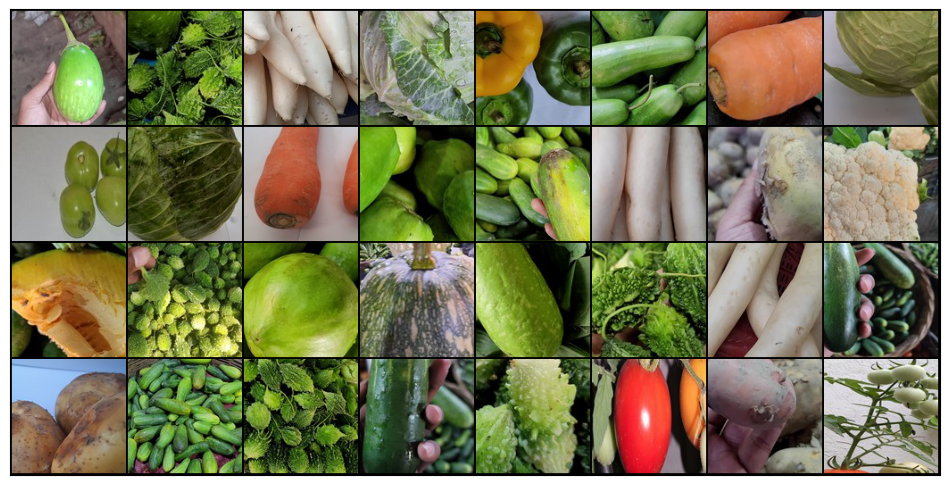

In [65]:
show_batch(train_dl)

## Using a GPU

We will define 2 helper functions that will check if we have a GPU available and will accordingly return a device object. The second function will move the data to the GPU. Lastly, we will also define a wrapper class named DeviceDataLoader it will be an extension for the data loader just that it will move the data to the device specified.

In [66]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
     

Now we will get our device and create objects from our newly made class. Which will also shift our data from the CPU to the GPU.

In [67]:
device = get_default_device()
device

device(type='cuda')

In [68]:
train_dl = DeviceDataLoader(train_dl , device)
valid_dl = DeviceDataLoader(valid_dl , device)
test_dl = DeviceDataLoader(test_dl, device)

Now we will define the accuracy function which will return the percentage of images that our model got correct. We will also define the image classification base class which will contain the methods every image classifer can use. We will use the cross entropy loss as its ideal for multiclass classification.

In [69]:
writer = SummaryWriter()

In [70]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        #writer.add_scalar("Loss/train", result['train_loss'].item(), epoch)
        #writer.add_scalar("Loss/val", result['val_loss'].item(), epoch)
        #writer.add_scalar("Accuracy/val", result['val_acc'].item(), epoch)
        #writer.flush()
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


For our problem, we will use the Resnet9 architecture we will seperately define repetitive parts like the convoloutional block so we can reuse the block with fewer lines of code. At the end, we will use a dropout of one which means it will randomly set some values to 0 to prevent overfitting. Then we will flatten the feature map and pass it to the linear layer which will give us 10 probabilities.

In [71]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), 
                                  conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), 
                                  conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.1),
                                        nn.Linear(25088 , 15))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out
     

We will now define the evaluate function which will evaluate a data loader and give us the accuracy and loss. We will also deine a get_lr function that will give us the learing rate from the optimizer. Lastly we will make a function to fit one cycle which will also use weight decays and gradient clipping.

In [72]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    model = to_device(ResNet9(3, classes), device)
    #writer.add_graph(model, torch.zeros(1, 3, 64, 64).to(device))
    #writer.close()
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            #lrs.append(get_lr(optimizer))
            #sched.step()
            #writer.add_scalar("Learning Rate", get_lr(optimizer), epoch * len(train_loader) + batch_idx)
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        #writer.close()
    return history
     

Now, we will set some hyperparameters for our model.

In [73]:
epochs = 1
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

We create a model and move it to the device, in my case a GPU.

In [74]:
model = to_device(ResNet9(3, classes), device)

In [ ]:
history = [evaluate(model, valid_dl)]
history

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)